<a href="https://colab.research.google.com/github/KauaHenSilva/python_identifies_human/blob/main/eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação

In [241]:
from google.colab.drive import mount
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import zipfile
import os
import numpy as np

In [242]:
# drive: https://drive.google.com/drive/folders/1OXTbhGlG6Y-x6hMY_5Y8Ed3mPB9lP5LF?usp=sharing
mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reconhecimento de faces com Eigenfaces

## Carregando base de dados

In [243]:
path = "/content/drive/MyDrive/Face Detection and Recognition/datasets/yalefaces.zip"
zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('./')
zip_obj.close()

## Deteção e recorte da face (SSD)

In [244]:
prototxt = "/content/drive/MyDrive/Face Detection and Recognition/weights/deploy.prototxt.txt"
model = "/content/drive/MyDrive/Face Detection and Recognition/weights/res10_300x300_ssd_iter_140000.caffemodel"
network = cv2.dnn.readNetFromCaffe(prototxt, model)

In [245]:
def run_ssd_recort(net, img_path, conf_min = 0.8, tamanho = 100):
    imagem = Image.open(img_path).convert("L")
    imagem = np.array(imagem, 'uint8')
    imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
    (h, w) = imagem.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (tamanho, tamanho)), 1.0, (tamanho, tamanho), (104, 117, 123))
    net.setInput(blob)
    deteccoes = net.forward()


    for i in range(0, deteccoes.shape[2]):
      confianca_atual = deteccoes[0, 0, i, 2]
      if confianca_atual >= conf_min:
        text_conf = f"{(confianca_atual * 100):.2f}%"
        box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (start_x, start_y, end_x, end_y) = box.astype(int)

        cv2.putText(imagem, f"{text_conf}", (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 0, lineType=cv2.LINE_AA)
        cv2.rectangle(imagem, (start_x - 1, start_y - 1), (end_x + 1, end_y + 1), (0,255,0), 1)
        face = imagem[start_y:end_y, start_x:end_x]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    return imagem, cv2.resize(face, (60, 80)), confianca_atual

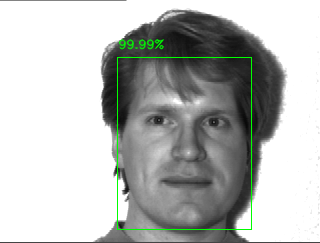

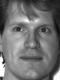

(0.0, (80, 60))

In [246]:
imagem_test = "/content/yalefaces/test/subject01.gif"
(img, face, confianca) = run_ssd_recort(network, imagem_test, 0.8)
cv2_imshow(img)
cv2_imshow(face)
confianca, face.shape

## Construção da base de dados

In [247]:
def get_imagens_data():
  path_past_train = "/content/yalefaces/train"
  paths = [os.path.join(path_past_train, f) for f in os.listdir(path_past_train)]

  imgs = []
  faces = []
  ids = []

  for path in paths:
    id = int(path.split('.')[0].split('subject')[-1])
    img, face, confianca =  run_ssd_recort(network, path, 0.7)
    cv2.putText(img, f"{id}", (20, img.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 0, lineType=cv2.LINE_AA)

    imgs.append(img)
    faces.append(face)
    ids.append(id)

  return imgs, faces, np.array(ids)

## Eigenfaces

In [248]:
_, faces, ids = get_imagens_data()
eigen_classifier = cv2.face.EigenFaceRecognizer_create()
eigen_classifier.train(faces, ids)
eigen_classifier.write("eigen_classifier.yml")

In [249]:
eigen_classifier = cv2.face.EigenFaceRecognizer_create()
eigen_classifier.read("/content/eigen_classifier.yml")

### test

In [250]:
test_img_path = "/content/yalefaces/test/subject01.gif"
(img_test, test_face, conf) = run_ssd_recort(network, test_img_path)
predict = eigen_classifier.predict(test_face)
predict

(1, 2961.431787322436)

In [251]:
saida_esperada = int(test_img_path.split('.')[0].split('subject')[-1])
saida_esperada

1

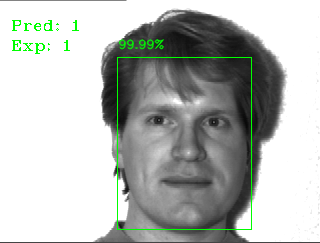

In [252]:
cv2.putText(img_test, 'Pred: ' + str(predict[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
cv2.putText(img_test, 'Exp: ' + str(saida_esperada), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
cv2_imshow(img_test)

### func facilitadora

In [253]:
def teste_reconhecimento(path_imagem_teste, classificador):
  img_test, face, conf = run_ssd_recort(network, path_imagem_teste)
  previsao, conf = classificador.predict(face)
  saida_esperada = int(path_imagem_teste.split('.')[0].split('subject')[-1])
  cv2.putText(img_test, 'Pred: ' + str(previsao), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  cv2.putText(img_test, 'Exp: ' + str(saida_esperada), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  return img_test, previsao


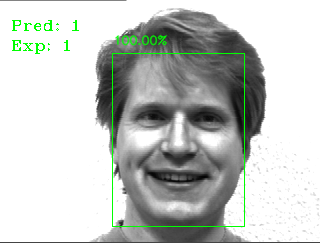

1

In [254]:
img, prev = teste_reconhecimento("/content/yalefaces/test/subject01.happy.gif", eigen_classifier)
cv2_imshow(img)
prev

## Avaliação

In [255]:
def avalia_algoritmo(paths, classificador):
  previsoes = []
  saidas_esperadas = []
  qtd_face_nao_reconhecida = 0

  for path in paths:
    img, face, conf = run_ssd_recort(network, path)
    previsao, conf = classificador.predict(face)
    saida_esperada = int(path.split('.')[0].split('subject')[-1])

    previsoes.append(previsao)
    saidas_esperadas.append(saida_esperada)

    if previsao == -1:
       qtd_face_nao_reconhecida += 1

  return np.array(previsoes), np.array(saidas_esperadas), qtd_face_nao_reconhecida

In [256]:
path_past_test = "/content/yalefaces/test"
paths = [os.path.join(path_past_test, f) for f in os.listdir(path_past_test)]
previsoes, saidas, qtd_nao_reconhecida = avalia_algoritmo(paths, eigen_classifier)
(previsoes, saidas, qtd_nao_reconhecida)

(array([ 7,  1, 12,  9, 15,  1,  9, 10,  5, 14,  2, 15,  6,  4,  1,  6, 11,
        13,  3, 12, 13,  8, 14, 11, 10, 13,  5,  8,  9,  1]),
 array([ 7, 15, 12,  2,  3,  1,  9, 10,  5, 14,  8, 15,  9,  4,  1,  6, 11,
        13,  3, 12, 13,  8, 14, 11, 10,  7,  5,  6,  2,  4]),
 0)

In [257]:
from sklearn.metrics import accuracy_score
accuracy_score(saidas, previsoes)

0.7

In [258]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(saidas, previsoes)
cm

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

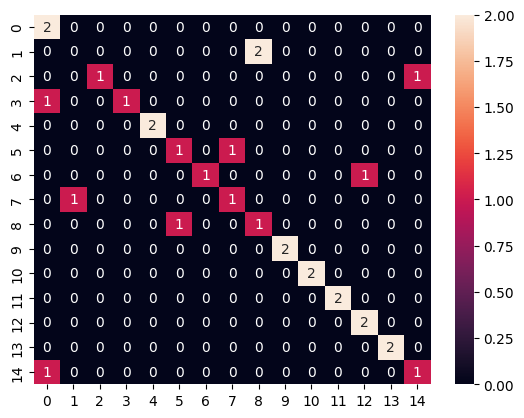

In [259]:
import seaborn
seaborn.heatmap(cm, annot=True);

## parametros Eigenfaces

In [260]:
def test_avaliacao_grafico(paths, classificador):
    previsoes, saidas, qtd_nao_reconhecida = avalia_algoritmo(paths, classificador)
    print(f"acuracia: {accuracy_score(saidas, previsoes)}", f"qtd não reconhecida: {qtd_nao_reconhecida}")
    seaborn.heatmap(confusion_matrix(saidas, previsoes), annot=True);

> num_compon

acuracia: 0.6666666666666666 qtd não reconhecida: 0


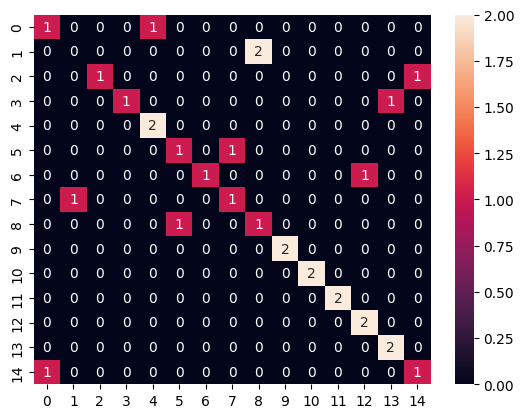

In [261]:
eigen_classifier_2 = cv2.face.EigenFaceRecognizer_create(40)
eigen_classifier_2.train(faces, ids)
test_avaliacao_grafico(paths, eigen_classifier_2)

acuracia: 0.6333333333333333 qtd não reconhecida: 0


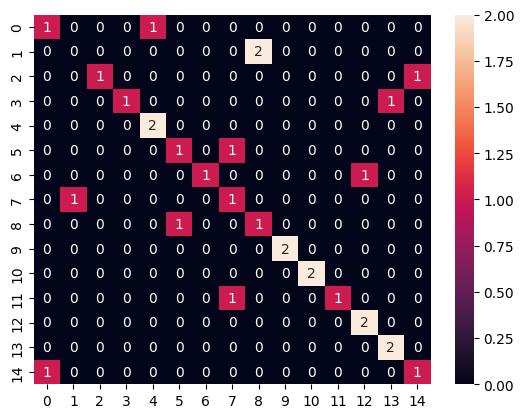

In [262]:
eigen_classifier_3 = cv2.face.EigenFaceRecognizer_create(20)
eigen_classifier_3.train(faces, ids)
test_avaliacao_grafico(paths, eigen_classifier_3)

acuracia: 0.7 qtd não reconhecida: 0


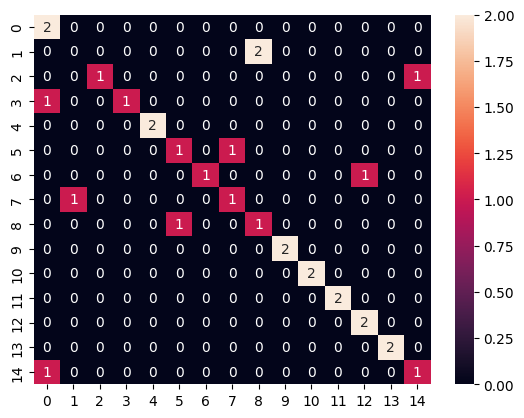

In [263]:
eigen_classifier_4 = cv2.face.EigenFaceRecognizer_create(145)
eigen_classifier_4.train(faces, ids)
test_avaliacao_grafico(paths, eigen_classifier_4)

> threshold

acuracia: 0.6 qtd não reconhecida: 7


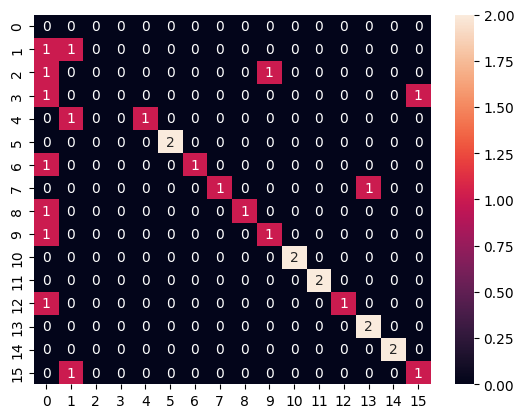

In [264]:
eigen_classifier_5 = cv2.face.EigenFaceRecognizer_create(145, 2500)
eigen_classifier_5.train(faces, ids)
test_avaliacao_grafico(paths, eigen_classifier_5)